In [128]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

In [129]:
@jit(nopython = True)
def init_wave_func(k0_prime, N, n_cicles):
    psi = np.zeros((n_cicles, N), dtype = np.cdouble)
    i = 1
    while(i < N-1):
        psi[0, i] = np.exp(1j*k0_prime*i)*np.exp((-8*(4*i-N)**2)/N**2)
        i += 1
    return psi

@jit(nopython = True)
def init_potential(k0_prime, lamb, N):
    V_prime = np.zeros(N)
    i = int(2*N/5)
    while(i < 3*N/5):
        V_prime[i] = lamb*k0_prime**2
        i += 1
    return V_prime

@jit(nopython = True)
def compute_norm(psi, n):
    return np.linalg.norm(psi[n])
    
@jit(nopython = True)
def compute_alpha(V_prime, s_prime, N):
    alpha = np.zeros(N, dtype = np.cdouble)
    i = N-1
    while(i > 0):
        alpha[i-1] = -1/(2+(2j/s_prime)-V_prime[i]+alpha[i])
        i -= 1
    return alpha

@jit(nopython = True)
def compute_beta(psi, alpha, V_prime, s_prime, N, n):
    b = np.zeros(N, dtype = np.cdouble)
    beta = np.zeros(N, dtype = np.cdouble)
    i = 0
    while(i < N):
        b[i] = 4j*psi[n][i]/s_prime
        i +=1
    i = N-1
    while(i > 0):
        beta[i-1] = (b[i]-beta[i])/(2+(2j/s_prime)-V_prime[i]+alpha[i])
        i -= 1  
    return beta     

@jit(nopython = True)
def compute_chi(alpha, beta, N):
    chi = np.zeros(N, dtype = np.cdouble)
    i = 0
    while(i < N):
        chi[i+1] = alpha[i]*chi[i] + beta[i]
        i += 1
    return chi

@jit(nopython = True)
def compute_wave_func(psi, chi, n):
    psi[n+1] = chi - psi[n]
    return psi

@jit(nopython = True)
def iterative_process(n_cicles, N, s, h, lamb):
    s_prime = s/h**2
    k0_prime = 2*np.pi*2/N

    psi = init_wave_func(k0_prime, N, n_cicles)
    V_prime = init_potential(k0_prime, lamb, N)
    alpha = compute_alpha(V_prime, s_prime, N)

    norm = np.zeros(n_cicles)

    i = 0
    while(i < n_cicles-1):
        beta = compute_beta(psi, alpha, V_prime, s_prime, N, i)
        chi = compute_chi(alpha, beta, N)
        psi = compute_wave_func(psi, chi, i)
        norm[i] = compute_norm(psi, i)
        i += 1
    return psi, norm

@jit(nopython = True)
def prob_density(psi, N, n_cicles):
    prob = np.zeros((n_cicles, N))
    i = 0
    while(i < n_cicles):
        prob[i] = np.absolute(psi[i])
        i += 1
    return prob


In [130]:
N= 1000
n_cicles = 1000
s = 0.0001
h = 0.01
lamb = 0.3

psi, norm = iterative_process(n_cicles, N, s, h, lamb)
prob = prob_density(psi, N, n_cicles)
print(prob)

[[0.00000000e+00 3.57588383e-04 3.81075896e-04 ... 9.55983986e-32
  7.89485259e-32 0.00000000e+00]
 [0.00000000e+00 3.25595823e-04 4.16194373e-04 ... 1.04701368e-31
  6.33647379e-32 2.91254658e-32]
 [0.00000000e+00 2.65928674e-04 4.45397820e-04 ... 1.03359208e-31
  4.49971274e-32 4.25079451e-32]
 ...
 [0.00000000e+00 2.98793459e-05 5.99297539e-05 ... 6.96166538e-06
  1.63769055e-06 9.30613860e-06]
 [0.00000000e+00 2.98579875e-05 5.99088393e-05 ... 9.17377604e-06
  1.64276752e-06 8.26499570e-06]
 [0.00000000e+00 2.98448328e-05 5.98780727e-05 ... 1.03166747e-05
  1.64338570e-06 7.53224689e-06]]


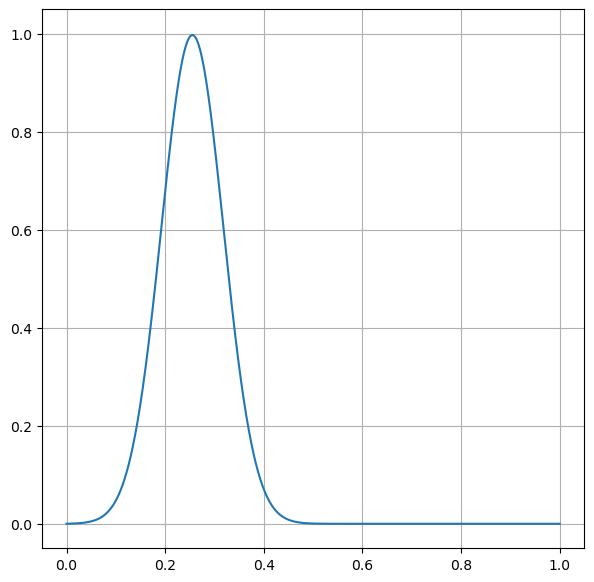

In [131]:
fig=plt.figure(figsize=(7,7)) #Size of the plot
ax=fig.add_subplot(111)

x = np.linspace(0, 1, N)
line, = ax.plot(x, prob[0])
plt.grid()

def animate (i, prob, line):
    line.set_ydata(prob[i])
    return line,

FFwriter = FFMpegWriter(fps=60, extra_args=['-vcodec', 'libx264'])

animation = FuncAnimation(fig, animate, fargs=(prob, line), frames=n_cicles, blit=True, interval=10)

animation.save("{}.mp4".format(f"schrodinger"), dpi=100, writer = FFwriter)